# Cross-site Pairing Tutorial

In this notebook, we perform a subset of the cross-site benchmarking.
Here, we use three of four sequencing sites as the paired bridge data.
We unpair cells from the fourth site and use scPairing and the artificial pairing procedure to re-pair these cells.

In [1]:
# Only for local use
import os
os.environ['NUMBA_CACHE_DIR'] = '/scratch/st-jiaruid-1/yinian/tmp/' # https://github.com/scverse/scanpy/issues/2113
os.environ['MPLCONFIGDIR'] = "/scratch/st-jiaruid-1/yinian/tmp/"

import warnings
warnings.filterwarnings("ignore")

In [2]:
import anndata as ad
import numpy as np
import scanpy as sc
import scib
import scipy
import sklearn
import torch

In [3]:
from scPairing import scPairing, foscttm

## Load the data

Download and unzip the `.h5ad` file from NCBI GEO.

In [ ]:
# Download the 2021 NeurIPS challenge dataset
!wget -O data/bmmc.h5ad.gz "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE194122&format=file&file=GSE194122%5Fopenproblems%5Fneurips2021%5Fcite%5FBMMC%5Fprocessed%2Eh5ad%2Egz"
!gzip -d data/bmmc.h5ad.gz

In [4]:
adata = ad.read_h5ad('data/bmmc.h5ad')

/arc/project/st-jiaruid-1/yinian/test_env/lib/python3.9/site-packages/anndata/_io/specs/registry.py:256: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/arc/project/st-jiaruid-1/yinian/test_env/lib/python3.9/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/GEX_pct_counts_mt' was written without encoding metadata.
  return func(*args, **kwargs)
/arc/project/st-jiaruid-1/yinian/test_env/lib/python3.9/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/GEX_n_counts' was written without encoding metadata.
  return func(*args, **kwargs)
/arc/project/st-jiaruid-1/yinian/test_env/lib/python3.9/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/GEX_n_genes' was written without encoding metadata.
  return func(*args, **kwargs)
/arc/project/st-jiaruid-1/yinian/test_env/lib/python3.9/site-packages/anndata/_io/utils.py:207: OldFormatWarning: 

In [5]:
rna_adata = adata[:, adata.var.feature_types == 'GEX'].copy()
atac_adata = adata[:, adata.var.feature_types == 'ATAC']. copy()

In [6]:
del adata

## Run scVI and PeakVI on three of four sites

This builds the model that we will transfer the fourth site onto.

In [7]:
import scvi

/arc/project/st-jiaruid-1/yinian/test_env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/xla.py:18: DeprecationWarning: `ModuleAvailableCache` is a special case of `RequirementCache`. Please use `RequirementCache(module=...)` instead.
  from lightning.fabric.accelerators.tpu import _XLA_AVAILABLE, TPUAccelerator
/arc/project/st-jiaruid-1/yinian/test_env/lib/python3.9/site-packages/lightning/fabric/__init__.py:36: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning.fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
/arc/project/st-jiaruid-1/yinian/test_env/lib/python3.9/site-packages/pkg_resources/__init__.py:2563: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning')`.
Implementing

In [8]:
scvi.settings.seed = 0

INFO: [rank: 0] Global seed set to 0
[2024-10-20 17:55:53,044] INFO - lightning.fabric.utilities.seed: [rank: 0] Global seed set to 0


### Subset the data to the first three sites

In [9]:
rna_adata_ref = rna_adata[~rna_adata.obs.batch.str.startswith('s4')].copy()
atac_adata_ref = atac_adata[~atac_adata.obs.batch.str.startswith('s4')].copy()

### Run scVI

In [10]:
scvi.model.SCVI.setup_anndata(rna_adata_ref, batch_key='batch', layer='counts')

/arc/project/st-jiaruid-1/yinian/test_env/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
[2024-10-20 17:56:06,188] INFO - jax._src.xla_bridge: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[2024-10-20 17:56:06,189] INFO - jax._src.xla_bridge: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[2024-10-20 17:56:06,192] INFO - jax._src.xla_bridge: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
[2024-10-20 17:56:06,194] WARNING - jax._src.xla_bridge: No GPU/TPU found, falling back to CPU. (

In [11]:
scvi_ref = scvi.model.SCVI(rna_adata_ref)
scvi_ref.train(early_stopping=True)

INFO: GPU available: True (cuda), used: True
[2024-10-20 17:56:06,683] INFO - lightning.pytorch.utilities.rank_zero: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
[2024-10-20 17:56:06,686] INFO - lightning.pytorch.utilities.rank_zero: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
[2024-10-20 17:56:06,689] INFO - lightning.pytorch.utilities.rank_zero: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
[2024-10-20 17:56:06,692] INFO - lightning.pytorch.utilities.rank_zero: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[2024-10-20 17:56:06,845] INFO - lightning.pytorch.accelerators.cuda: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
[2024-10-20 17:56:06,850] INFO - lightning.pytorch.trainer.connectors.signal_connector: SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 1/170:   0%|          | 0/170 [00:00<?, ?it/s]

/arc/project/st-jiaruid-1/yinian/test_env/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 170/170: 100%|██████████| 170/170 [15:52<00:00,  5.57s/it, v_num=1, train_loss_step=4.26e+3, train_loss_epoch=4.04e+3]

INFO: `Trainer.fit` stopped: `max_epochs=170` reached.
[2024-10-20 18:11:59,406] INFO - lightning.pytorch.utilities.rank_zero: `Trainer.fit` stopped: `max_epochs=170` reached.


Epoch 170/170: 100%|██████████| 170/170 [15:52<00:00,  5.60s/it, v_num=1, train_loss_step=4.26e+3, train_loss_epoch=4.04e+3]


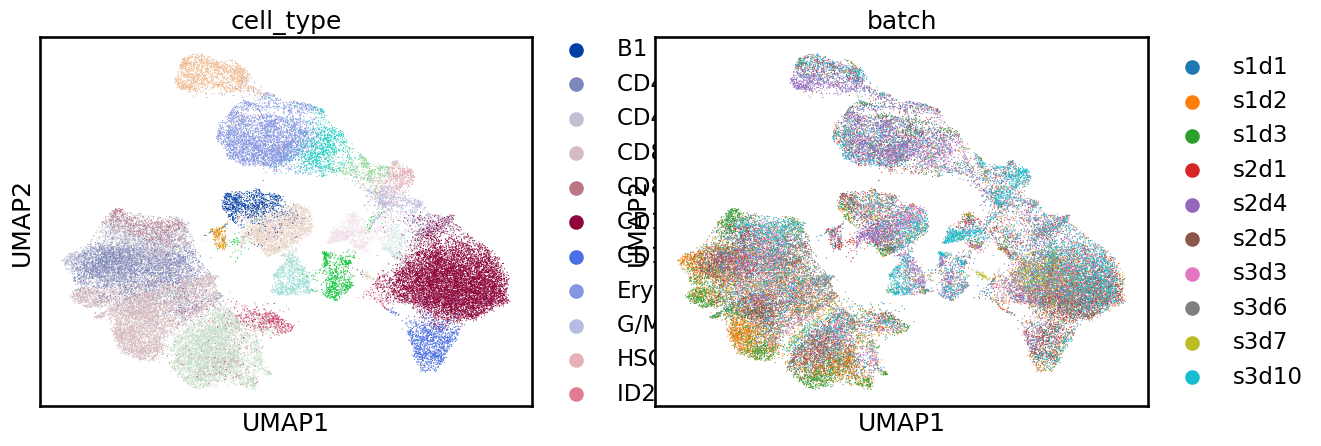

In [12]:
latents = scvi_ref.get_latent_representation()
rna_adata_ref.obsm['X_scVI'] = latents

sc.pp.neighbors(rna_adata_ref, use_rep='X_scVI', random_state=0)
sc.tl.umap(rna_adata_ref, random_state=0)
sc.pl.umap(rna_adata_ref, color=['cell_type', 'batch'])

In [13]:
scvi_ref.save(dir_path='data', prefix='scvi_ref_', overwrite=True)

### Run PeakVI

In [14]:
scvi.model.PEAKVI.setup_anndata(atac_adata_ref, batch_key="batch", layer="counts")

In [15]:
peakvi_ref = scvi.model.PEAKVI(atac_adata_ref)
peakvi_ref.train(early_stopping=True)

INFO: GPU available: True (cuda), used: True
[2024-10-20 18:13:40,010] INFO - lightning.pytorch.utilities.rank_zero: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
[2024-10-20 18:13:40,014] INFO - lightning.pytorch.utilities.rank_zero: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
[2024-10-20 18:13:40,017] INFO - lightning.pytorch.utilities.rank_zero: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
[2024-10-20 18:13:40,020] INFO - lightning.pytorch.utilities.rank_zero: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[2024-10-20 18:13:40,150] INFO - lightning.pytorch.accelerators.cuda: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
[2024-10-20 18:13:40,154] INFO - lightning.pytorch.trainer.connectors.signal_connector: SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 81/500:  16%|█▌        | 81/500 [1:06:04<5:41:46, 48.94s/it, v_num=1, train_loss_step=7.86e+7, train_loss_epoch=1.75e+8]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 11351.985. Signaling Trainer to stop.


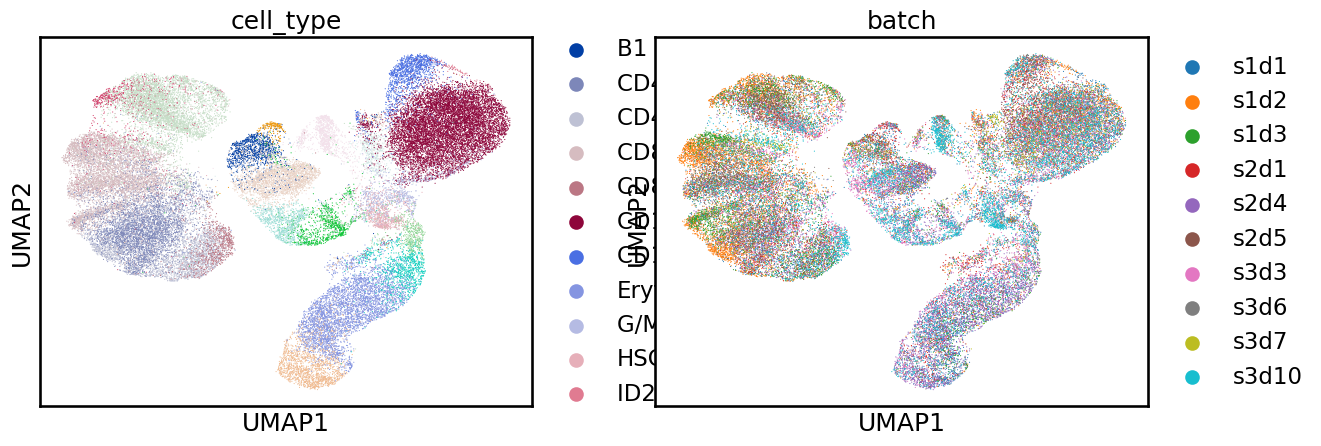

In [16]:
latents = peakvi_ref.get_latent_representation()
atac_adata_ref.obsm['X_PeakVI'] = latents

sc.pp.neighbors(atac_adata_ref, use_rep='X_PeakVI', random_state=0)
sc.tl.umap(atac_adata_ref, random_state=0)
sc.pl.umap(atac_adata_ref, color=['cell_type', 'batch'])

In [17]:
peakvi_ref.save(dir_path='data', prefix='peakvi_ref_', overwrite=True)

### Perform mapping on the individual modalities

We subset the full data for the fourth site and map the data onto the three training sites.

In [18]:
rna_adata_val = rna_adata[rna_adata.obs.batch.str.startswith('s4')].copy()
atac_adata_val = atac_adata[atac_adata.obs.batch.str.startswith('s4')].copy()

In [19]:
scvi.model.SCVI.prepare_query_anndata(rna_adata_val, scvi_ref)

INFO     Found 100.0% reference vars in query data.                                                                


In [20]:
scvi_query = scvi.model.SCVI.load_query_data(rna_adata_val, scvi_ref)
scvi_query.train(max_epochs=200, early_stopping=True, plan_kwargs={"weight_decay": 0.0})

INFO: GPU available: True (cuda), used: True
[2024-10-20 19:22:12,075] INFO - lightning.pytorch.utilities.rank_zero: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
[2024-10-20 19:22:12,079] INFO - lightning.pytorch.utilities.rank_zero: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
[2024-10-20 19:22:12,081] INFO - lightning.pytorch.utilities.rank_zero: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
[2024-10-20 19:22:12,084] INFO - lightning.pytorch.utilities.rank_zero: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[2024-10-20 19:22:12,096] INFO - lightning.pytorch.accelerators.cuda: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
[2024-10-20 19:22:12,101] INFO - lightning.pytorch.trainer.connectors.signal_connector: SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 95/200:  48%|████▊     | 95/200 [04:15<04:42,  2.69s/it, v_num=1, train_loss_step=2.53e+3, train_loss_epoch=2.49e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 2551.007. Signaling Trainer to stop.


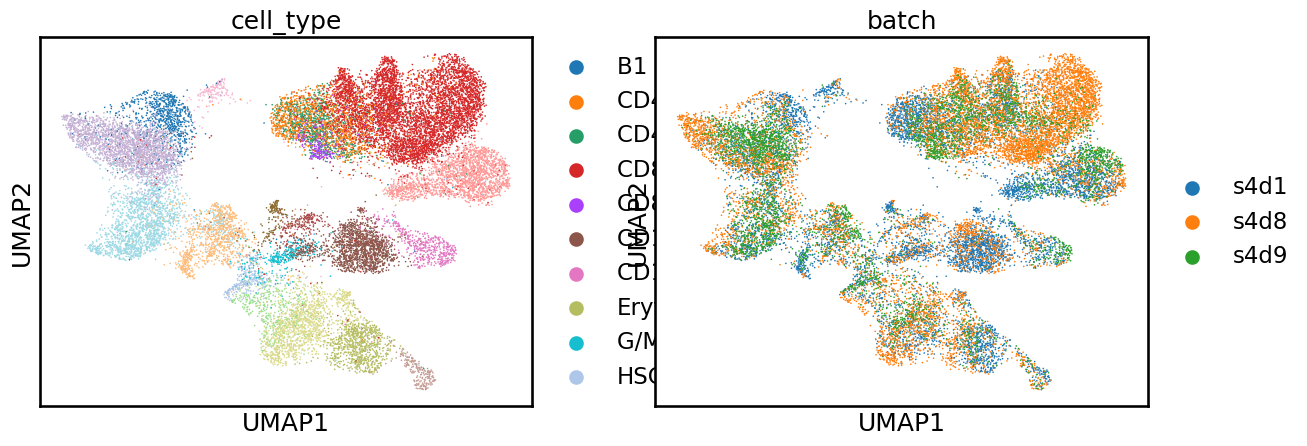

In [21]:
latents = scvi_query.get_latent_representation()
rna_adata_val.obsm['X_scVI'] = latents

sc.pp.neighbors(rna_adata_val, use_rep='X_scVI', random_state=0)
sc.tl.umap(rna_adata_val, random_state=0)
sc.pl.umap(rna_adata_val, color=['cell_type', 'batch'])

In [22]:
scvi_query.save(dir_path='data', prefix='scvi_query_', overwrite=True)

In [23]:
scvi.model.PEAKVI.prepare_query_anndata(atac_adata_val, peakvi_ref)

INFO     Found 100.0% reference vars in query data.                                                                


In [24]:
peakvi_query = scvi.model.PEAKVI.load_query_data(atac_adata_val, peakvi_ref)

In [25]:
peakvi_query.train(max_epochs=200, early_stopping=True, plan_kwargs={"weight_decay": 0.0})

INFO: GPU available: True (cuda), used: True
[2024-10-20 19:26:57,554] INFO - lightning.pytorch.utilities.rank_zero: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
[2024-10-20 19:26:57,558] INFO - lightning.pytorch.utilities.rank_zero: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
[2024-10-20 19:26:57,560] INFO - lightning.pytorch.utilities.rank_zero: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
[2024-10-20 19:26:57,563] INFO - lightning.pytorch.utilities.rank_zero: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[2024-10-20 19:26:57,575] INFO - lightning.pytorch.accelerators.cuda: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
[2024-10-20 19:26:57,580] INFO - lightning.pytorch.trainer.connectors.signal_connector: SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 200/200: 100%|██████████| 200/200 [2:12:42<00:00, 30.15s/it, v_num=1, train_loss_step=1.45e+7, train_loss_epoch=2.09e+8]  

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
[2024-10-20 21:39:39,852] INFO - lightning.pytorch.utilities.rank_zero: `Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [2:12:42<00:00, 39.81s/it, v_num=1, train_loss_step=1.45e+7, train_loss_epoch=2.09e+8]


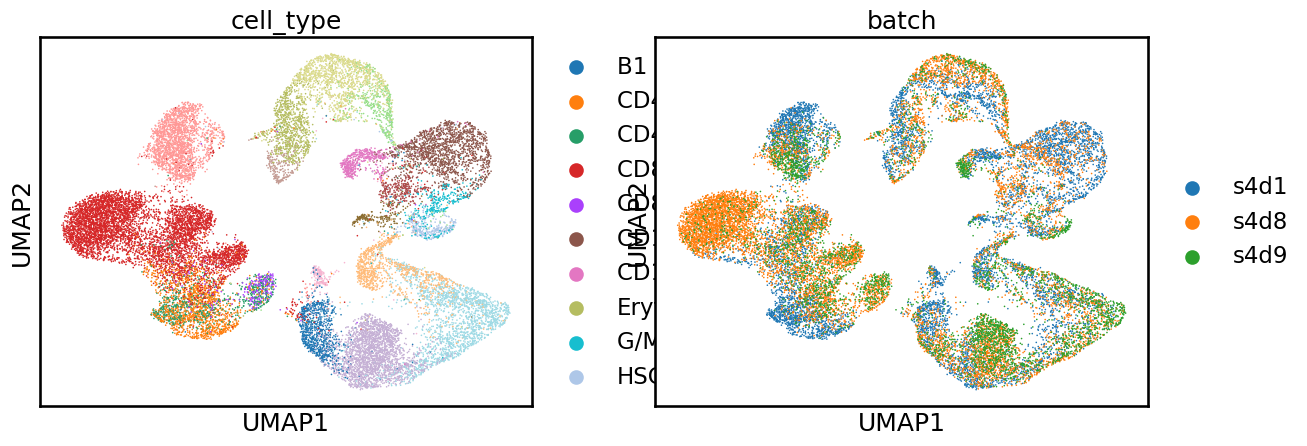

In [26]:
latents = peakvi_query.get_latent_representation()
atac_adata_val.obsm['X_PeakVI'] = latents

sc.pp.neighbors(atac_adata_val, use_rep='X_PeakVI', random_state=0)
sc.tl.umap(atac_adata_val, random_state=0)
sc.pl.umap(atac_adata_val, color=['cell_type', 'batch'])

In [27]:
peakvi_query.save(dir_path='data', prefix='peakvi_query_', overwrite=True)

### Reload scVI and PeakVI models

If the models were previously run, we can reload the models and re-compute the embeddings.

In [28]:
scvi_ref = scvi.model.SCVI.load(dir_path='data/', adata=rna_adata_ref, prefix='scvi_ref_')
scvi_query = scvi.model.SCVI.load(dir_path='data/', adata=rna_adata_val, prefix='scvi_query_')
peakvi_ref = scvi.model.PEAKVI.load(dir_path='data/', adata=atac_adata_ref, prefix='peakvi_ref_')
peakvi_query = scvi.model.PEAKVI.load(dir_path='data/', adata=atac_adata_val, prefix='peakvi_query_')

INFO     File data/scvi_ref_model.pt already downloaded                                                            


/arc/project/st-jiaruid-1/yinian/test_env/lib/python3.9/site-packages/scvi/model/base/_utils.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_pa

INFO     File data/scvi_query_model.pt already downloaded                                                          


/arc/project/st-jiaruid-1/yinian/test_env/lib/python3.9/site-packages/scvi/model/base/_utils.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_pa

INFO     File data/peakvi_ref_model.pt already downloaded                                                          


/arc/project/st-jiaruid-1/yinian/test_env/lib/python3.9/site-packages/scvi/model/base/_utils.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_pa

INFO     File data/peakvi_query_model.pt already downloaded                                                        


/arc/project/st-jiaruid-1/yinian/test_env/lib/python3.9/site-packages/scvi/model/base/_utils.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_pa

In [29]:
rna_adata_ref.obsm['X_scVI'] = scvi_ref.get_latent_representation()
rna_adata_val.obsm['X_scVI'] = scvi_query.get_latent_representation()
atac_adata_ref.obsm['X_PeakVI'] = peakvi_ref.get_latent_representation()
atac_adata_val.obsm['X_PeakVI'] = peakvi_query.get_latent_representation()

## Run scPairing

The following code allows for using the scVI and PeakVI as pre-trained decoders. These two functions manipulate the scVI and PeakVI functionality to take in a latent representation and decode it into count data.

**Warning**: This function does not seem to work with the latest version of scvi-tools. We run it with scvi-tools version 1.0.2.

In [30]:
def reconstruct_mod1(scvi_model):
    def f(mod2_features, true_features, counts, library_size, cell_indices, is_training, is_imputation, batch_indices=None):
        if is_training:
            return None, 0
        if batch_indices is None:
            batch_indices = torch.zeros(mod2_features.shape[0], device=mod2_features.device)
        library_size = torch.log(library_size) if not is_imputation else torch.ones((mod2_features.shape[0], 1))
        res = scvi_model.module.generative(mod2_features, library_size, batch_indices.reshape((mod2_features.shape[0], 1)))
        if is_imputation:
            return res['px'].mu, None
        loss = -res['px'].log_prob(counts).sum(-1).mean()
        return res['px'].mu, loss
    return f

def reconstruct_mod2(pvi_model):
    def f(mod1_features, true_features, counts, library_size, cell_indices, is_training, is_imputation, batch_indices=None):
        if is_training:
            return None, 0
        if batch_indices is None:
            batch_indices = torch.zeros(mod1_features.shape[0], device=mod1_features.device)
        res = pvi_model.module.generative(mod1_features, mod1_features, batch_indices.reshape((mod1_features.shape[0], 1)))
        if is_imputation:
            return res['p'], None
        dres = pvi_model.module.d_encoder(counts, batch_indices, ())
        region_factors = torch.sigmoid(pvi_model.module.region_factors)
        loss = pvi_model.module.get_reconstruction_loss(res['p'], dres, region_factors, counts).mean()
        return res['p'], loss
    return f

Now that the bridge and query data have batch-corrected low-dimensional representations, we can run scPairing to re-pair the query cells.

Here, we set `use_decoder` to `True` to allow the model to fully reconstruct the count data.
To indicate that we are using pre-trained decoders, we set the `reconstruct_mod1_fn` and `reconstruct_mod2_fn` to be the functions defined above.

In [31]:
model = scPairing(
    rna_adata_ref,
    atac_adata_ref,
    "rna", "atac",
    counts_layer=['counts', 'counts'],
    transformed_obsm=['X_scVI', 'X_PeakVI'],
    use_decoder=True,
    reconstruct_mod1_fn=reconstruct_mod1(scvi_ref),
    reconstruct_mod2_fn=reconstruct_mod2(peakvi_ref),
    seed=0
)

In [32]:
model.train(epochs = 300, batch_size=5000)

[2024-10-20 21:43:11,790] INFO - scPairing.logging_utils: UnsupervisedTrainer.__init__(Model(
  (mod1_encoder): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
  (mod2_encoder): Sequential(
    (0): Linear(in_features=18, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
  (var_encoder): ConcentrationEncoder(
    (mod1_encoder): Sequential(
      (0): Linear(in_features=10, out_features=32, bias=True)
      (1): ELU(alpha=1.0)
      (2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_fea

[2024-10-20 21:43:12,270] INFO - scPairing.trainers.UnsupervisedTrainer: ==========Epoch 0==========
[2024-10-20 21:43:12,272] INFO - scPairing.trainers.UnsupervisedTrainer: lr          :        0.005
[2024-10-20 21:43:12,274] INFO - scPairing.trainers.UnsupervisedTrainer: kl_weight   :        0.001
[2024-10-20 21:43:12,276] INFO - scPairing.trainers.trainer_utils: loss        :      18.34
[2024-10-20 21:43:12,277] INFO - scPairing.trainers.trainer_utils: contrastive :      15.26
[2024-10-20 21:43:12,279] INFO - scPairing.trainers.trainer_utils: KL          :    0.05144
[2024-10-20 21:43:12,281] INFO - scPairing.trainers.trainer_utils: mod1_loss   :      1.441
[2024-10-20 21:43:12,282] INFO - scPairing.trainers.trainer_utils: mod2_loss   :      2.293
[2024-10-20 21:43:12,284] INFO - scPairing.trainers.trainer_utils: temp        :      14.29
[2024-10-20 21:43:12,286] INFO - scPairing.trainers.trainer_utils: mod1_reconstruction_loss:          0
[2024-10-20 21:43:12,288] INFO - scPairing.

[2024-10-20 21:44:49,072] INFO - scPairing.trainers.UnsupervisedTrainer: ==========Epoch 300==========
[2024-10-20 21:44:49,074] INFO - scPairing.trainers.UnsupervisedTrainer: lr          :     0.004221
[2024-10-20 21:44:49,075] INFO - scPairing.trainers.UnsupervisedTrainer: kl_weight   :        0.001
[2024-10-20 21:44:49,078] INFO - scPairing.trainers.trainer_utils: loss        :      3.989
[2024-10-20 21:44:49,080] INFO - scPairing.trainers.trainer_utils: contrastive :      5.013
[2024-10-20 21:44:49,082] INFO - scPairing.trainers.trainer_utils: KL          :      13.93
[2024-10-20 21:44:49,084] INFO - scPairing.trainers.trainer_utils: mod1_loss   :     0.3137
[2024-10-20 21:44:49,086] INFO - scPairing.trainers.trainer_utils: mod2_loss   :     0.2737
[2024-10-20 21:44:49,088] INFO - scPairing.trainers.trainer_utils: temp        :      33.12
[2024-10-20 21:44:49,090] INFO - scPairing.trainers.trainer_utils: mod1_reconstruction_loss:          0
[2024-10-20 21:44:49,092] INFO - scPairin

In [33]:
latents = model.get_latent_representation()

In [34]:
rna_adata_ref.obsm['mod1_features'] = atac_adata_ref.obsm['mod1_features'] = latents[0]
rna_adata_ref.obsm['mod2_features'] = atac_adata_ref.obsm['mod2_features'] = latents[1]

### Visualize and evaluate the embeddings

Visualization of the concatenated embeddings for the bridge data.

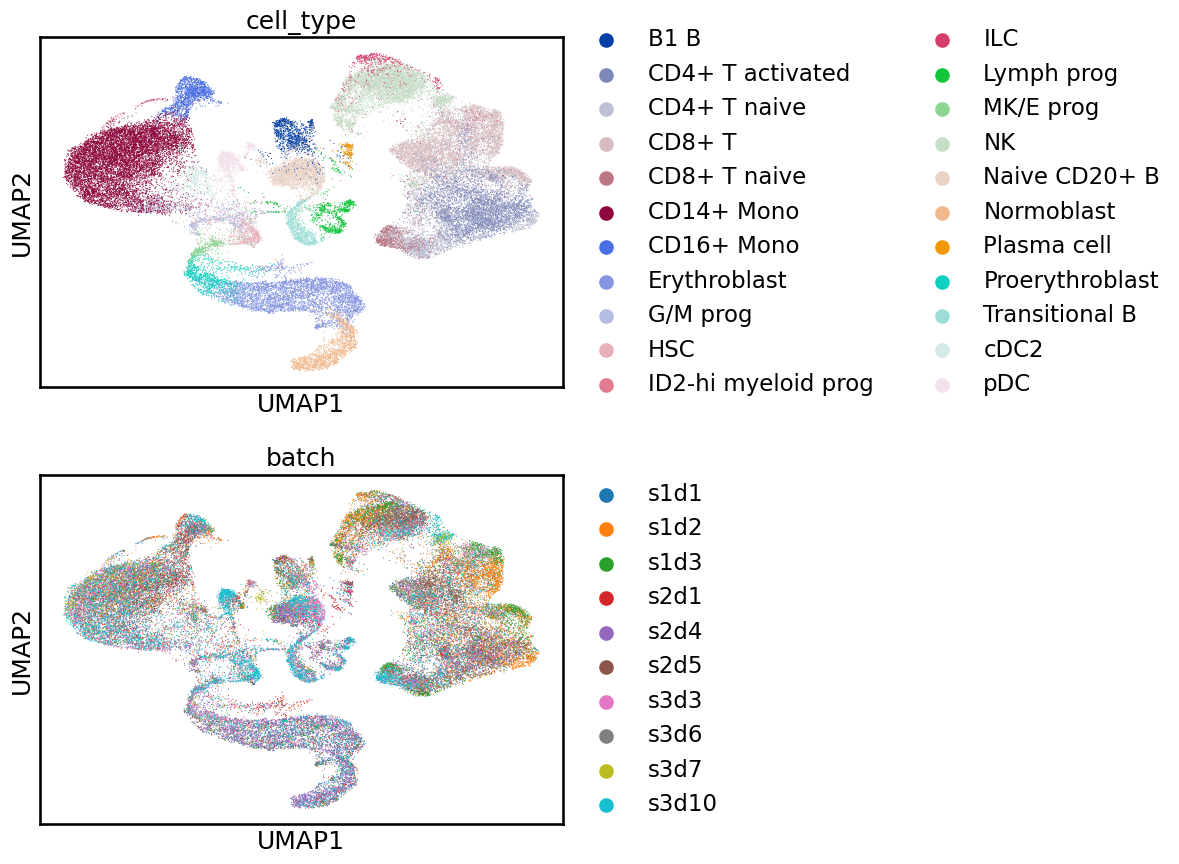

In [35]:
concat = np.concatenate((rna_adata_ref.obsm['mod1_features'], atac_adata_ref.obsm['mod2_features']), axis=1)
rna_adata_ref.obsm['concat'] = concat

sc.pp.neighbors(rna_adata_ref, use_rep='concat', random_state=0)
sc.tl.umap(rna_adata_ref, random_state=0)
sc.pl.umap(rna_adata_ref, color=['cell_type', 'batch'], ncols=1)

Visualization and evaluation of modality alignment:

/arc/project/st-jiaruid-1/yinian/test_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


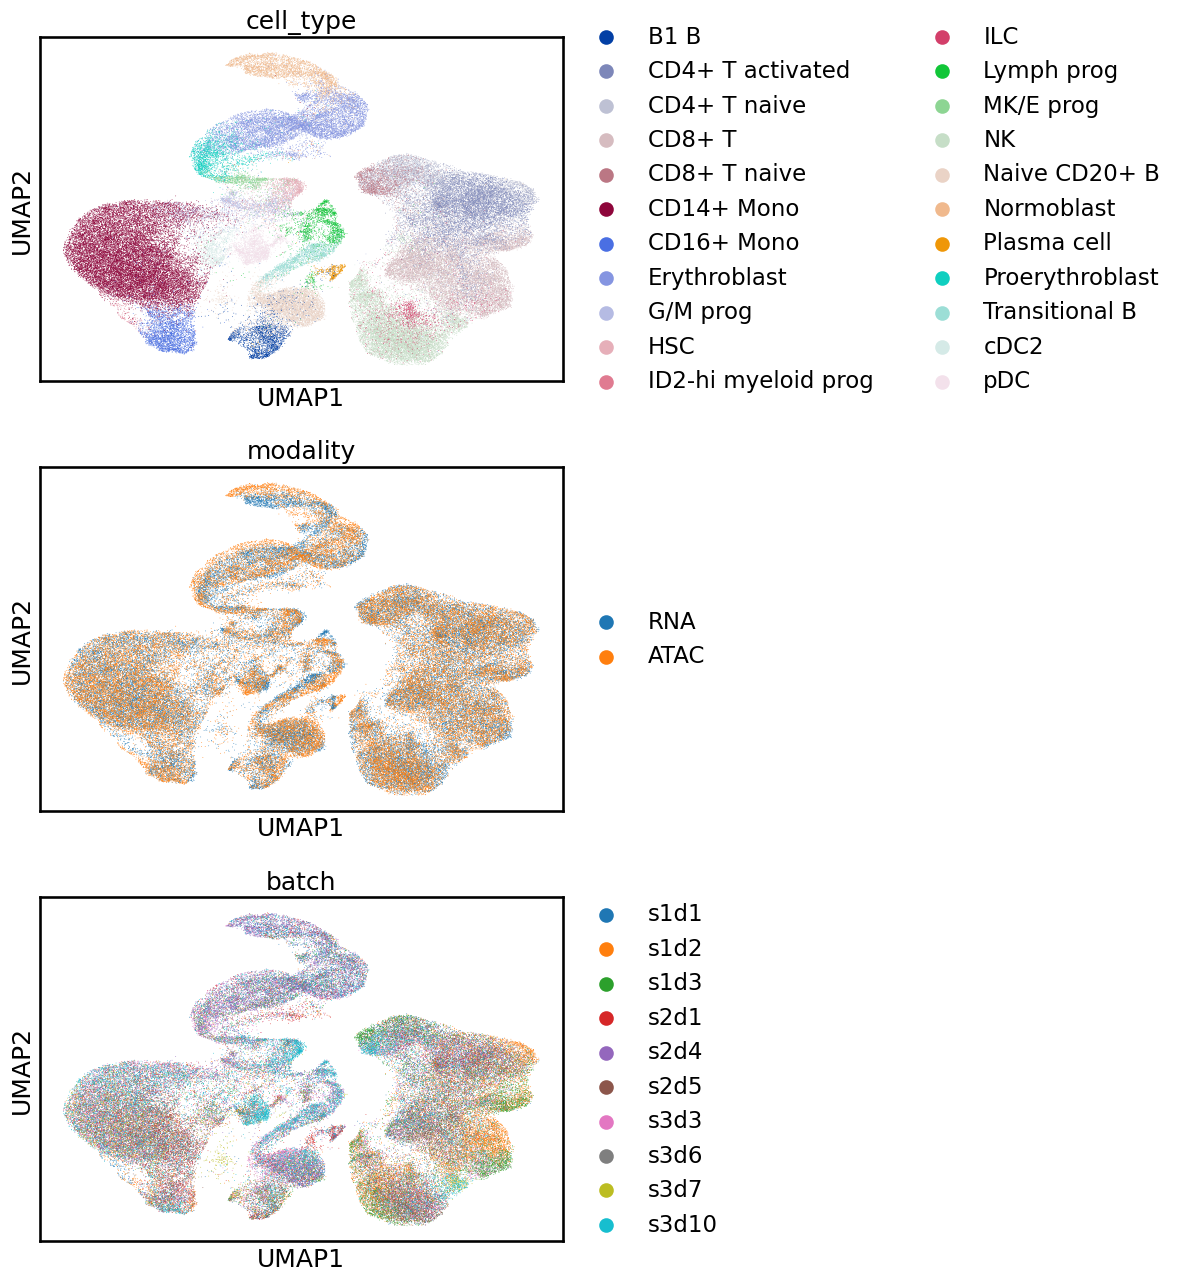

In [36]:
concat_feat = np.concatenate([rna_adata_ref.obsm['mod1_features'], atac_adata_ref.obsm['mod2_features']])
concat = ad.concat([rna_adata_ref, rna_adata_ref], label='modality', keys=['RNA', 'ATAC'])
concat.obsm['concat_feat'] = concat_feat

sc.pp.neighbors(concat, use_rep='concat_feat')
sc.tl.umap(concat)
sc.pl.umap(concat, color=['cell_type', 'modality', 'batch'], ncols=1)

In [37]:
scib.me.ilisi_graph(concat, batch_key="modality", type_="knn") # 0.7756322746795763

/arc/project/st-jiaruid-1/yinian/test_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


0.7881890497695636

In [38]:
del concat

In [39]:
scores = foscttm(rna_adata_ref.obsm['mod1_features'], atac_adata_ref.obsm['mod2_features'])
scores[0].mean(), scores[1].mean()

(0.01119845252943549, 0.011197260045543432)

## Map the query data onto the common embedding space

In [40]:
test_latents = model.get_latent_representation(rna_adata_val, atac_adata_val)
rna_adata_val.obsm['mod1_features'] = atac_adata_val.obsm['mod1_features'] = test_latents[0]
rna_adata_val.obsm['mod2_features'] = atac_adata_val.obsm['mod2_features'] = test_latents[1]

### Visualize the mappings

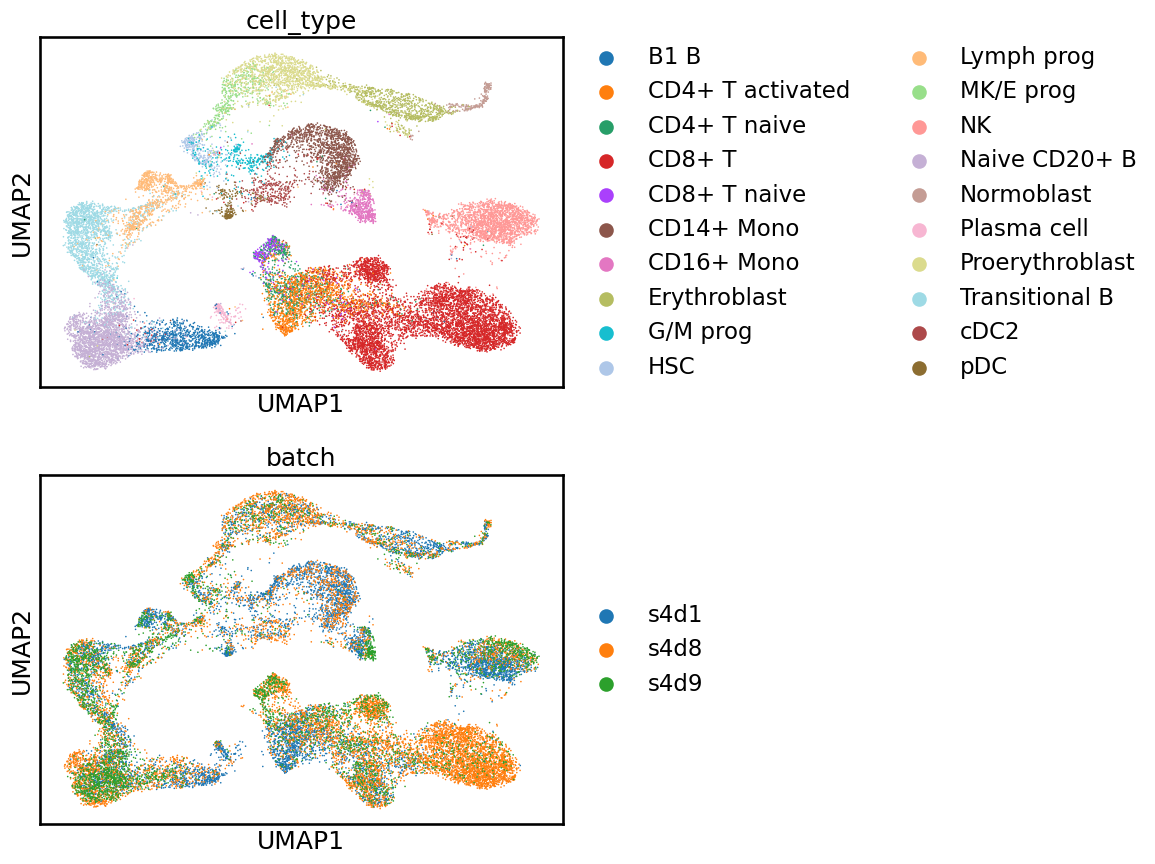

In [41]:
concat = np.concatenate((rna_adata_val.obsm['mod1_features'], atac_adata_val.obsm['mod2_features']), axis=1)
rna_adata_val.obsm['concat'] = concat

sc.pp.neighbors(rna_adata_val, use_rep='concat')
sc.tl.umap(rna_adata_val)
sc.pl.umap(rna_adata_val, color=['cell_type', 'batch'], ncols=1)

/arc/project/st-jiaruid-1/yinian/test_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


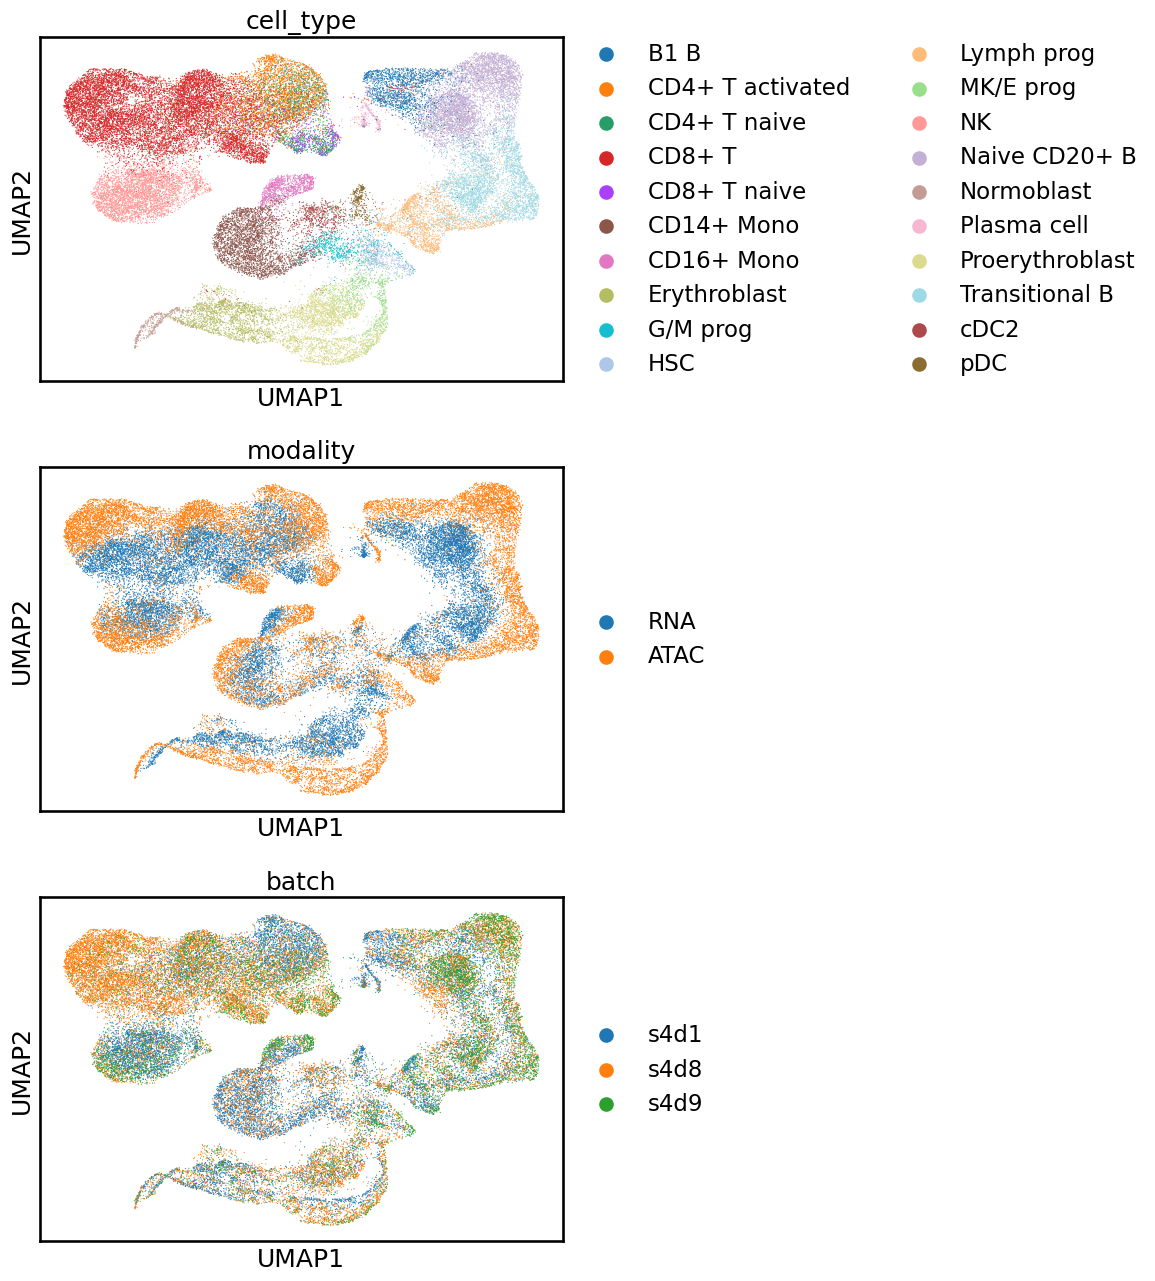

In [42]:
concat_feat = np.concatenate([rna_adata_val.obsm['mod1_features'], atac_adata_val.obsm['mod2_features']])
concat = ad.concat([rna_adata_val, rna_adata_val], label='modality', keys=['RNA', 'ATAC'])
concat.obsm['concat_feat'] = concat_feat

sc.pp.neighbors(concat, use_rep='concat_feat')
sc.tl.umap(concat)
sc.pl.umap(concat, color=['cell_type', 'modality', 'batch'], ncols=1)

In [43]:
scib.me.ilisi_graph(concat, batch_key="modality", type_="knn")

/arc/project/st-jiaruid-1/yinian/test_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


0.0935845837680156

In [44]:
del concat

In [45]:
scores = foscttm(rna_adata_val.obsm['mod1_features'], atac_adata_val.obsm['mod2_features'])
scores[0].mean(), scores[1].mean()

(0.029350179658413505, 0.03280890741483662)

## Cross-modality imputation from scATAC-seq to scRNA-seq

We evaluate how well the pre-trained decoders can impute the scRNA-seq data.

In [46]:
impute_rna, _ = model.get_cross_modality_expression(False, atac_adata_val)

Perform PCA to observe the structure of the imputations

In [47]:
imputed_adata = ad.AnnData(impute_rna, atac_adata_val.obs, rna_adata_val.var)

In [48]:
sc.pp.pca(imputed_adata)

In [49]:
sc.pp.neighbors(imputed_adata, random_state=0)
sc.tl.umap(imputed_adata, random_state=0)

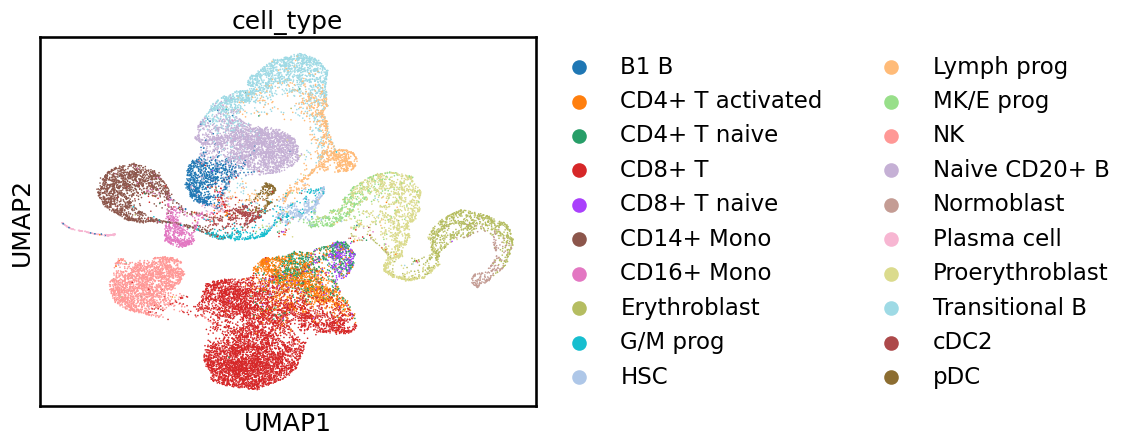

In [50]:
sc.pl.umap(imputed_adata, color='cell_type')

Compute correlations with the original scRNA-seq data

In [51]:
def correlation(y_true, y_pred, method='spearman'):
    """
    Modified from: https://www.kaggle.com/code/xiafire/lb-t15-msci-multiome-catboostregressor#Predicting
    """
    if y_true.shape != y_pred.shape:
        raise ValueError("Shapes are different.")
    corrsum = 0
    for i in range(len(y_true)):
        if method == 'spearman':
            corrsum += scipy.stats.spearmanr(y_true[i], y_pred[i]).statistic
        elif method == 'pearson':
            corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)

In [52]:
correlation(rna_adata_val.layers['counts'].toarray(), impute_rna, method='spearman')

0.24793249790870145

In [53]:
correlation(rna_adata_val.layers['counts'].toarray(), impute_rna, method='pearson')

0.6273453475575057

## Re-pair the cells

To re-pair the cells, we use the embeddings on the common embedding space to perform maximum weight bipartite graph matching.

In [54]:
m1 = rna_adata_val.obsm['mod1_features']
m2 = atac_adata_val.obsm['mod2_features']
dist_matrix = sklearn.metrics.pairwise.cosine_similarity(m1, m2)

# Set a cutoff to prevent dissimilar cells from being paired together
dist_matrix[dist_matrix < 0.90] = 0

In [55]:
# row_ind contains the indices used in the RNA data, col_ind contains the indices used in the ATAC data.
row_ind, col_ind = scipy.optimize.linear_sum_assignment(dist_matrix, maximize=True)

# linear_sum_assignment will still assign pairings even if the weight is 0.
# valid_pairings captures these "false" pairings
valid_pairings = dist_matrix[row_ind, col_ind] != 0

In [56]:
# The number of successfully paired cells
valid_pairings.sum(), rna_adata_val.n_obs

(21899, 22224)

Re-arrange the RNA and ATAC data to be the re-paired data

In [57]:
rna_adata_val = rna_adata_val[row_ind[valid_pairings]]
atac_adata_val = atac_adata_val[col_ind[valid_pairings]]

rna_adata_val, atac_adata_val

(View of AnnData object with n_obs × n_vars = 21899 × 13431
     obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', '_scvi_batch', '_scvi_labels'
     var: 'feature_types', 'gene_id'
     uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'cell_type_colors', 'batch_colors'
     obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_scVI', 'X_umap', 'mod1_features', 'mod2_features', 'concat'
     layers: 'counts'
     obsp: 'distances', 'connectivities'

How many RNA profiles were paired to an ATAC profile of the same type.

In [58]:
sum([rna_adata_val.obs.cell_type[i] == atac_adata_val.obs.cell_type[i] for i in range(rna_adata_val.n_obs)]), rna_adata_val.n_obs

/tmp/slurm/2968434/ipykernel_2920894/2488571634.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sum([rna_adata_val.obs.cell_type[i] == atac_adata_val.obs.cell_type[i] for i in range(rna_adata_val.n_obs)]), rna_adata_val.n_obs


(17615, 21899)